# MSDS 7331 - Mini Lab: Logistic Regression and SVMs

### Investigators
- [Matt Baldree](mailto:mbaldree@smu.edu?subject=lab1)
- [Tom Elkins](telkins@smu.edu?subject=lab1)
- [Austin Kelly](ajkelly@smu.edu?subject=lab1)
- [Murali Parthasarathy](mparthasarathy@smu.edu?subject=lab1)


<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:5px;'>
    <h3>Lab Instructions</h3>
    <p>You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.
Write a report covering all the steps of the project. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the rendered iPython notebook. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.</p>
</div>

<a id='data_prep'></a>
## 1 - Data Preparation

In [56]:
#1.0.1 - Import the libraries we will need
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Read in the crime data from the Lab 1 CSV file
dc = pd.read_csv('data/DC_Crime_2015_Lab1.csv')

### *** TO DO:
###  * Incorporate a feature for the weather conditions during START_DATE and END_DATE so we can use rainfall/max temp/min temp in the regression
dc['REPORT_DAT'] = pd.to_datetime(dc['REPORT_DAT'])
dc=dc.rename(columns = {'REPORT_DAT':'REPORT_DATE'})
dc['START_DATE'] = pd.to_datetime(dc['START_DATE'])
dc['END_DATE'] = pd.to_datetime(dc['END_DATE'])
dc['XBLOCK'] = dc['XBLOCK'].astype(np.float64)
dc['YBLOCK'] = dc['YBLOCK'].astype(np.float64)
dc['Crime_Month'] = dc["END_DATE"].map(lambda x: x.month)
dc['Crime_WeekDay'] = dc["END_DATE"].map(lambda x:x.dayofweek)
dc['Crime_Weekend'] = dc["Crime_WeekDay"] > 5
dc['Crime_Weekend'] = dc['Crime_Weekend'].astype(np.int64)

dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 29 columns):
REPORT_DATE             36489 non-null datetime64[ns]
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null datetime64[ns]
END_DATE                36489 non-null datetime64[ns]
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int6

In [39]:
print "---==< Crime Type vs Weekend >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Crime_Weekend)
print "---==< Crime Type vs Day of week >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Crime_WeekDay)
print "---==< Crime Type vs Month >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Crime_Month)
print "---==< Crime Type vs Shift >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.SHIFT)
print "---==< Crime Type vs District >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.DistrictID)
print "---==< Crime Type vs PSA >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.PSA_ID)
print "---==< Crime Type vs Ward >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.WARD)
print "---==< Crime Type vs ANC >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.ANC)
print "---==< Crime Type vs Neighborhood >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.NEIGHBORHOOD_CLUSTER)
print "---==< Crime Type vs Tract >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.CENSUS_TRACT)
print "---==< Crime Type vs Precinct >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.VOTING_PRECINCT)
print "---==< Crime Type vs Latitude >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Latitude)
print "---==< Crime Type vs Longitude >==---"
print pd.crosstab(dc.CRIME_TYPE, dc.Longitude)


---==< Crime Type vs Weekend >==---
Crime_Weekend  False  True 
CRIME_TYPE                 
1               5203    970
2              26442   3874
---==< Crime Type vs Day of week >==---
Crime_WeekDay     0     1     2     3     4     5     6
CRIME_TYPE                                             
1               825   826   854   861   838   999   970
2              4152  4297  4383  4232  4912  4466  3874
---==< Crime Type vs Month >==---
Crime_Month    1     2     3     4     5     6     7     8     9     10    11  \
CRIME_TYPE                                                                      
1             438   283   456   510   553   537   640   567   519   586   514   
2            2419  1595  2026  2430  2836  2891  2995  2873  2553  2657  2442   

Crime_Month    12  
CRIME_TYPE         
1             570  
2            2599  
---==< Crime Type vs Shift >==---
SHIFT         DAY  EVENING  MIDNIGHT
CRIME_TYPE                          
1            1244     2566      2363
2   

### 1.1 - Dataset Review
We continue to use our dataset selected for lab 1 - the 2015 Washington, D.C. Metro Crime data.  That dataset contained the type of crime committed (Field name "OFFENSE"; from which we derived an "Offense_Code" field and ascribed a numeric value for each offense type (NOTE: The number used does not imply a level of severity they were simply applied in order of appearance).  :

|Offense|Offense_Code|Crime_Type|
|:------|:----------:|---------:|
|Theft/Other|1|2 (Property)|
|Theft from Auto|2|2 (Property)|
|Burglary|3|2 (Property)|
|Assault with Dangerous Weapon|4|1 (Violent)|
|Robbery|5|1 (Violent)|
|Motor Vehicle Theft|6|2 (Property)|
|Homicide|7|1 (Violent)|
|Sex Abuse|8|1 (Violent)|
|Arson|9|2 (Property)|

The dataset contains a variety of geographic identifiers representing different political, social, and legal boundaries.

DISTRICT -- the Police district within which the crime was committed<br>
Police Service Area (PSA) -- A subordinate area within a District<br>
Ward -- A political area, similar to a "county" in a larger state<br>
Advisory Neighborhood Committed (ANC) -- A social group consisting of neighbors and social leaders in a small geographic area<br>
Voting Precinct -- A political area for the management of voting residents<br>
Local Coordinates (XBLOCK and YBLOCK) -- location within the DC metro area based on the Maryland mapping system<br>
Global Coordinates (Latitude and Longitude) -- location on the planet<br>

There are also time-based identifiers provided in the data
* The Start and End dates/times of when the crime *might* have been committed.
* The date/time the crime was reported (i.e. when the police responded and took the report)
* These can be further decomposed to Seasons, Months, Weeks, Day of the Week, etc.
* Shift - the police duty shift that responded to the crime (broken into 8-hour periods within a day)

From these time-based data we could associate environmental conditions as well, including temperatures, rainfall, phase of the moon, etc.

These features give us a variety of ways to attempt to classify the data.

### 1.2 - Classification Tasks
We decided to take a look at two different classification processes with our data set.

#### 1.2.1 - Crime_Type (Violent/Property)
The first classification task is a binary classification, in which we attempt to build a model to predict whether the crime will be against a person (violent) or against property given the other features of the data (geographic location, time of day, political area, etc.). The goal is to help the Police manage resources more appropriately.

#### 1.2.2 - Offense/Offense_Code
For the second classification task, we chose to attempt building a model to predict the type of offense (theft, homicide, assault, arson, etc.).  The hope is that if a type of crime could be predicted, then the Police would be better able to allocate offense-specific resources appropriately.

#### 1.2.3 - Model Comparison
Secondarily, we seek to compare the accuracy of the models - i.e. if the Crime_Type prediction indicates a "Violent" crime, does the Offense prediction agree (Homicide, Sex Abuse, Robbery, or Assault).


<a id="model_building"></a>
## 2 - Model Building

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>SVM and Logistic Regression Modeling</h3>
    <ol><li>[<b>50 points</b>] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.</li>
    <li>[<b>10 points</b>]  Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</li>
    <li>[<b>30 points</b>] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?</li>
    <li>[<b>10 points</b>]  Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.</li>
</ol>
</div>

### 2.1 - Logistic Regression Model for Crime_Type (Rubric Item 1)

In [123]:
#2.1.1 Dataset creation

#  The field "CRIME_TYPE" exists as 1 = Violent, and 2 = Property.  
#  We subtract from 2 to make it 1 = Violent, and 0 = Property
LRM_Response = 2 - dc["CRIME_TYPE"]
#print LRM_Response

def RateModel(modelScore,meanResponse):
    print "Mean response for this data set is ", meanResponse
    
    print "Model accuracy against this data set is ", modelScore
    
    guessRate = 1.0 - meanResponse
    print "If we simply guessed 'Property' crime all the time, our accuracy would be ", guessRate
    
    if modelScore > guessRate:
        print "The model predictions are better than simply guessing"
    elif modelScore == guessRate:
        print "The model predictions are the same as guessing"
    else:
        print "The model predictions are worse than simply guessing"
  

In [124]:
#2.1.2 Model
#  Set up model using all location and time features
LRM_Features = dc[["PSA_ID","WARD","ANC","NEIGHBORHOOD_CLUSTER","CENSUS_TRACT","VOTING_PRECINCT","SHIFT_Code","Latitude","Longitude","Crime_Month","Crime_WeekDay","Crime_Weekend"]]
#print LRM_Features

#  Fit our model
LRM_Model = LogisticRegression()
LRM_Model.fit(LRM_Features, LRM_Response)

Predictions = LRM_Model.predict(LRM_Features)

#  How accurate is it?
Model_Acc = metrics.accuracy_score(LRM_Response,Predictions)
Model_Conf = metrics.confusion_matrix(LRM_Response,Predictions)
print Model_Conf
RateModel(Model_Acc,LRM_Response.mean())

[[29826   490]
 [ 5710   463]]
Mean response for this data set is  0.169174271698
Model accuracy against this data set is  0.830085779276
If we simply guessed 'Property' crime all the time, our accuracy would be  0.830825728302
The model predictions are worse than simply guessing


So - that was disappointing.  Let's see if the coefficients tell us anything

In [63]:
#2.1.3 Coefficients
#  Display the coefficients to see if they tell us anything
pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)))

,0,1
0,PSA_ID,[0.0016715182337]
1,WARD,[0.02519289025]
2,ANC,[0.00857732241178]
3,NEIGHBORHOOD_CLUSTER,[-0.00267141763472]
4,CENSUS_TRACT,[-1.4691226441e-05]
5,VOTING_PRECINCT,[0.00137199014256]
6,SHIFT_Code,[0.808714709683]
7,Latitude,[-0.0181908490376]
8,Longitude,[0.0484740365001]
9,Crime_Month,[0.00693169744857]


* The SHIFT has the biggest impact (by over an order of magnitude compared to all other features).  Each SHIFT value represents an 8-hour period in the day.
  * This suggests we should look at decreasing the period of time to smaller than 8 hours
* Weekends have the second-largest impact. So time is apparently more important than location
* Longitude has the third-largest impact.  The fact that it is positive implies that the odds of being a victim of a violent crime increases as we travel East, holding all other factors constant.
* The political Ward has the fourth largest impact, implying that being in certain Wards increases one's odds of being a victim of a violent crime, holding all other factors constant.

The factors with the smallest magnitude coefficients were all location based:
* CENSUS_TRACT = 0 (effectively)
* VOTING_PRECINCT = 0.0013
* Police Service Area = 0.0016 (I believe this implies that the Police are equally effective in all of their service areas)
* NEIGHBOORHOOD_CLUSTER = -0.0026

This points to removing some of the location factors, and increasing the resolution in time factors to less than 8-hour periods.

Ah - but first we need to normalize the factors to get a better feel for their impacts

In [125]:
#2.1.4 - Split into training and test sets (80/20)
LRM_XTrain, LRM_XTest, LRM_YTrain, LRM_YTest = train_test_split(LRM_Features, LRM_Response, test_size=0.2, random_state=0)

#2.1.5 - Feature normalization  (From class notebook #4)
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
Scaler.fit(LRM_XTrain)

# Now we transform our data based on the scaler
Scaled_XTrain = Scaler.transform(LRM_XTrain)
Scaled_XTest = Scaler.transform(LRM_XTest)

# Fit the model against the scaled training data
LRM_Model.fit(Scaled_XTrain,LRM_YTrain)

# Generate predictions on the test set
Predictions2 = LRM_Model.predict(Scaled_XTest)

Model_Acc2 = metrics.accuracy_score(LRM_YTest,Predictions2)
Model_Conf2 = metrics.confusion_matrix(LRM_YTest,Predictions2)
print Model_Conf2
RateModel(Model_Acc2,LRM_YTest.mean())

pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)))


[[5934   67]
 [1213   84]]
Mean response for this data set is  0.177719923267
Model accuracy against this data set is  0.82460948205
If we simply guessed 'Property' crime all the time, our accuracy would be  0.822280076733
The model predictions are better than simply guessing


,0,1
0,PSA_ID,[0.285026573794]
1,WARD,[0.444046347375]
2,ANC,[-0.205681385291]
3,NEIGHBORHOOD_CLUSTER,[-0.0917364065521]
4,CENSUS_TRACT,[-0.105322468391]
5,VOTING_PRECINCT,[0.0155255343109]
6,SHIFT_Code,[0.58197792074]
7,Latitude,[-0.0361619305714]
8,Longitude,[0.190144141221]
9,Crime_Month,[0.0355280726126]


Now, with normalized coefficients, we see that:

* The SHIFT still has the biggest impact, but not as much as it had unscaled.  Each SHIFT value represents an 8-hour period in the day.
  * This still suggests we should look at decreasing the period of time to smaller than 8 hours
* Day of the week, Weekends, and Month have dropped in impact, and location-based factors have increased in importance
* Political Wards have the second-largest impact.
* Police Service Area has the third-largest impact.
* Advisory Neighborhood Committee has the fourth-largest impact.

Other trends of note:
* Longitude still has a positive coefficient, implying that one's odds of being the victim of a violent crime increases as one heads east (holding all other factors constant).
* One's odds of being the victim of a violent crime is greater on the weekends than during the week (holding all other factors constant).
* Latitude has a negative coefficient, implying that one's odds of being the victim of a violent crime increases as one heads south (holding all other factors constant).
* The day of the week has a negative coefficient, implying that one's odds of being the victim of a violent crime decreases as the week progresses [Weekdays are numbered 0=Monday ... 6=Sunday] (holding all other factors constant), but the Weekend factor has a positive coefficient several orders of magnitude higher, which is contradictory.

Cautions:
* Shift, Ward, PSA, ANC, and Day of the week are categorical, not ordinal, so we need to one-hot encode these features to get more resolution on *how* they impact the odds of being a victim of violent crime.
* This will **drastically** increase the number of explanatory variables.

In [127]:
#2.1.6 Feature adjustments
dc['Crime_Hour'] = dc["END_DATE"].map(lambda x:x.hour)
tmp_df = pd.get_dummies(dc.Crime_Hour,prefix="Hour")
dc_expanded = pd.concat((dc,tmp_df),axis=1)
tmp_df = pd.get_dummies(dc.WARD,prefix='Ward')
dc_expanded = pd.concat((dc_expanded,tmp_df),axis=1)
tmp_df = pd.get_dummies(dc.PSA_ID,prefix='PSA')
dc_expanded = pd.concat((dc_expanded,tmp_df),axis=1)
tmp_df = pd.get_dummies(dc.ANC,prefix='ANC')
dc_expanded = pd.concat((dc_expanded,tmp_df),axis=1)
tmp_df = pd.get_dummies(dc.Crime_Month,prefix='Month')
dc_expanded = pd.concat((dc_expanded,tmp_df),axis=1)

#2.1.7 - Remove unnecessary columns
if 'REPORT_DATE' in dc_expanded:
    del dc_expanded['REPORT_DATE']
if 'SHIFT' in dc_expanded:
    del dc_expanded['SHIFT']
if 'OFFENSE' in dc_expanded:
    del dc_expanded['OFFENSE']
if 'METHOD' in dc_expanded:
    del dc_expanded['METHOD']
if 'DISTRICT' in dc_expanded:
    del dc_expanded['DISTRICT']
if 'PSA' in dc_expanded:
    del dc_expanded['PSA']
if 'WARD' in dc_expanded:
    del dc_expanded['WARD']  # We now have dummies for each Ward
if 'ANC' in dc_expanded:
    del dc_expanded['ANC']   # We now have dummies for each ANC
if 'NEIGHBORHOOD_CLUSTER' in dc_expanded:
    del dc_expanded['NEIGHBORHOOD_CLUSTER']
if 'CENSUS_TRACT' in dc_expanded:
    del dc_expanded['CENSUS_TRACT']
if 'VOTING_PRECINCT' in dc_expanded:
    del dc_expanded['VOTING_PRECINCT']
if 'CCN' in dc_expanded:
    del dc_expanded['CCN']
if 'XBLOCK' in dc_expanded:
    del dc_expanded['XBLOCK']
if 'YBLOCK' in dc_expanded:
    del dc_expanded['YBLOCK']
if 'START_DATE' in dc_expanded:
    del dc_expanded['START_DATE']
if 'END_DATE' in dc_expanded:
    del dc_expanded['END_DATE']
if 'DistrictID' in dc_expanded:
    del dc_expanded['DistrictID'] # We can derive the District from the PSA
if 'PSA_ID' in dc_expanded:
    del dc_expanded['PSA_ID'] # We now have dummies for each PSA
if 'SHIFT_Code' in dc_expanded:
    del dc_expanded['SHIFT_Code'] # We now have hours
if 'OFFENSE_Code' in dc_expanded:
    del dc_expanded['OFFENSE_Code']
if 'METHOD_Code' in dc_expanded:
    del dc_expanded['METHOD_Code']
if 'AGE' in dc_expanded:
    del dc_expanded['AGE']
if 'TIME_TO_REPORT' in dc_expanded:
    del dc_expanded['TIME_TO_REPORT']
if 'Crime_Hour' in dc_expanded:
    del dc_expanded['Crime_Hour']
if 'Crime_WeekDay' in dc_expanded:
    del dc_expanded['Crime_WeekDay']
if 'Crime_Month' in dc_expanded:
    del dc_expanded['Crime_Month'] # We now have dummies for each month
if 'CRIME_TYPE' in dc_expanded:
    del dc_expanded['CRIME_TYPE'] # Our response variable, because it exists in LRM_Response still

#2.1.8 - Split into training and test sets (80/20)
LRM_XTrain3, LRM_XTest3, LRM_YTrain3, LRM_YTest3 = train_test_split(dc_expanded, LRM_Response, test_size=0.2, random_state=0)

Scaler.fit(LRM_XTrain3)

# Now we transform our data based on the scaler
Scaled_XTrain3 = Scaler.transform(LRM_XTrain3)
Scaled_XTest3 = Scaler.transform(LRM_XTest3)

# Fit the model against the scaled training data
LRM_Model.fit(Scaled_XTrain3,LRM_YTrain3)

# Generate predictions on the test set
Predictions3 = LRM_Model.predict(Scaled_XTest3)

Model_Acc3 = metrics.accuracy_score(LRM_YTest3,Predictions3)
Model_Conf3 = metrics.confusion_matrix(LRM_YTest3,Predictions3)
print Model_Conf3
RateModel(Model_Acc3,LRM_YTest3.mean())


[[5876  125]
 [1151  146]]
Mean response for this data set is  0.177719923267
Model accuracy against this data set is  0.825157577418
If we simply guessed 'Property' crime all the time, our accuracy would be  0.822280076733
The model predictions are better than simply guessing


---==< Coefficients in descending order of magnitude >==---
        Factor          Coefficient
29      Ward_3      [0.67236454643]
48     PSA_206    [-0.460623106813]
30      Ward_4     [0.441330303013]
102     ANC_33    [-0.389506652475]
33      Ward_7    [-0.386657519841]
101     ANC_32    [-0.332699774612]
104     ANC_35    [-0.331584807222]
99      ANC_25     [0.331108686704]
125     ANC_76     [0.308536954955]
108     ANC_42    [-0.278095056587]
121     ANC_72     [0.265539614062]
107     ANC_41    [-0.247468392769]
105     ANC_36    [-0.244294013844]
103     ANC_34    [-0.231564229755]
10      Hour_7    [-0.224339016019]
129     ANC_84     [0.216713236534]
3       Hour_0       [0.2023998601]
44     PSA_202    [-0.199790394715]
1    Longitude     [0.193777738807]
109     ANC_43    [-0.192396060014]
130     ANC_85     [0.191137336948]
13     Hour_10    [-0.190384963257]
26     Hour_23     [0.189382940236]
124     ANC_75     [0.187372940902]
122     ANC_73     [0.187298233447]
27  

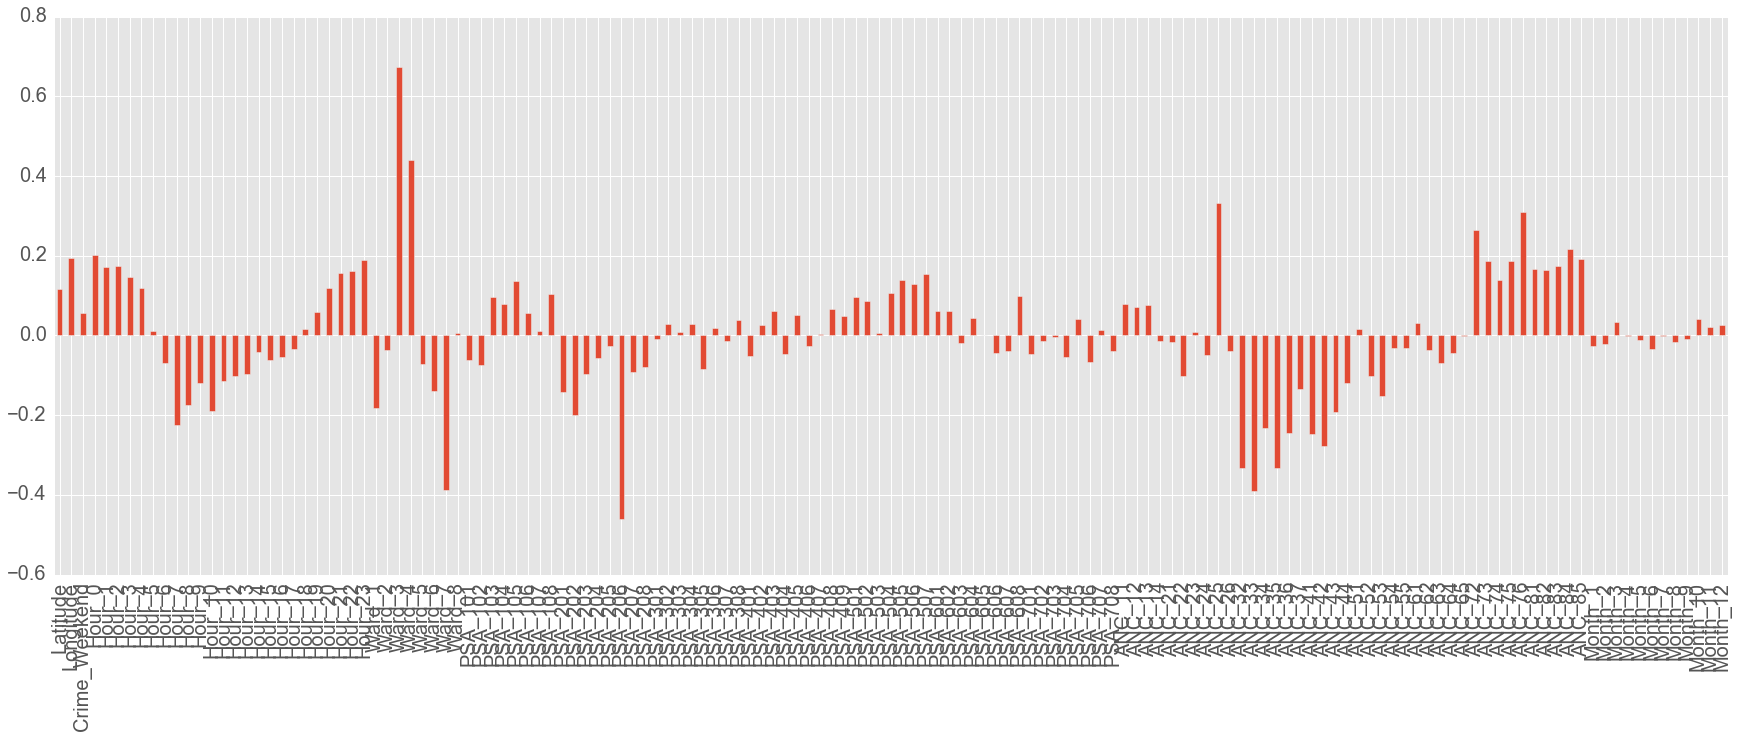

In [108]:
#2.1.9
#  Display the coefficients to see if they tell us anything
coefs = pd.DataFrame(zip(dc_expanded.columns, np.transpose(LRM_Model.coef_)), columns=['Factor','Coefficient'])
print "---==< Coefficients in descending order of magnitude >==---"
print coefs.reindex(coefs.Coefficient.abs().sort_values(ascending=False).index)

plt.figure(figsize=(30,10))
plt.style.use('ggplot')
weights = pd.Series(LRM_Model.coef_[0],index=dc_expanded.columns)
weights.plot(kind='bar')
plt.show()

There is an interesting cyclic trend with the hour of the day that implies that from 6PM to 6AM, one's odds of being a victim of a violent crime are greater than during the period from 6AM to 6PM.  This trend spans two Police duty shifts (Evening shift is 3PM to 11PM, Midnight shift is 11PM to 7AM, and Day shift is 7AM to 3PM) 

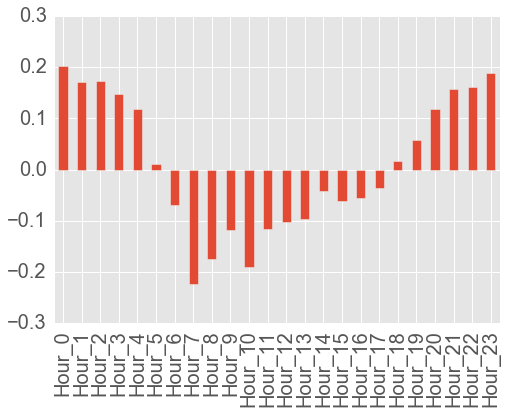

In [104]:
weights[["Hour_0","Hour_1","Hour_2","Hour_3","Hour_4","Hour_5","Hour_6","Hour_7","Hour_8","Hour_9","Hour_10","Hour_11","Hour_12","Hour_13","Hour_14","Hour_15","Hour_16","Hour_17","Hour_18","Hour_19","Hour_20","Hour_21","Hour_22","Hour_23"]].plot(kind='bar')
plt.show()

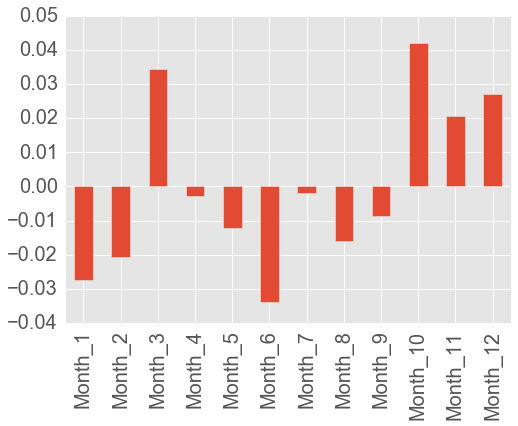

In [105]:
weights[["Month_1","Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12"]].plot(kind='bar')
plt.show()

In [117]:
# Now we try PCA to reduce the 143 features to something more manageable, but less interpretable

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit(dc_expanded).transform(dc_expanded) # fit data and then transform it
print 'pca:', pca.components_


pca: [[  1.24282629e-03   2.83459006e-02   7.30892260e-03  -1.59647860e-04
    5.46906930e-04  -9.57098924e-03  -6.11922528e-03   2.86067322e-03
    4.31433680e-03   9.15370111e-03   1.60256071e-02   1.52297718e-02
    1.14524622e-02   7.11488610e-03   2.39846871e-03  -5.95329374e-03
   -1.42465834e-02  -1.84890445e-02  -8.15801312e-03  -8.10000087e-03
   -7.88067097e-03  -6.57160492e-03  -1.17780784e-03  -9.42781821e-04
    6.89587703e-03   8.26949715e-03   3.10747535e-03   2.01881575e-01
   -7.61870342e-01   1.15857852e-02   3.71945506e-02   1.24763370e-01
    2.74630881e-01   6.59946528e-02   4.58195275e-02  -8.43178278e-02
   -6.61952503e-02   1.94624015e-02   4.99210425e-02   2.49309478e-02
    2.93981326e-02   5.68370736e-02   3.36259194e-02   1.75203483e-03
    3.95852270e-03   2.40941753e-03   2.92411674e-03   1.10472026e-03
   -1.14211675e-01  -1.67687091e-01  -1.73407005e-01  -5.64743532e-02
    6.37249671e-02   1.81364774e-02   2.45513713e-02   2.75698990e-02
    1.37099229e

In [128]:
dc_pca = pd.DataFrame(X_pca)
print dc_pca.ix[1234]

PCA_XTrain4, PCA_XTest4, PCA_YTrain4, PCA_YTest4 = train_test_split(dc_pca, LRM_Response, test_size=0.2, random_state=0)

# Fit the model against the PCA training data
LRM_Model.fit(PCA_XTrain4,PCA_YTrain4)

# Generate predictions on the test set
Predictions4 = LRM_Model.predict(PCA_XTest4)

Model_Acc4 = metrics.accuracy_score(PCA_YTest4,Predictions4)
Model_Conf4 = metrics.confusion_matrix(PCA_YTest4,Predictions4)
print Model_Conf4
RateModel(Model_Acc4,PCA_YTest4.mean())

0    0.418091
1   -1.070953
2   -0.615148
3   -0.261067
4    0.142105
Name: 1234, dtype: float64
[[6001    0]
 [1297    0]]
Mean response for this data set is  0.177719923267
Model accuracy against this data set is  0.822280076733
If we simply guessed 'Property' crime all the time, our accuracy would be  0.822280076733
The model predictions are the same as guessing


Attempting to reduce the one-hot-encoded values returned us to the original problem that guessing 'Property' all the time is just as accurate.  In fact, according to the confusion matrix, that is exactly what the model did -- classified everything as a property crime.
Let's go back to our 143 factor model and perform a 10-fold cross-validation to see if this is a stable model.

In [129]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), dc_expanded, LRM_Response, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.83068493  0.83068493  0.82986301  0.81583996  0.05727597  0.64154563
  0.80866228  0.75109649  0.08360746  0.24972588]
0.589898653309


The answer is no - this is not a good model.

### 2.2 - Support Vector Machine Model for Crime_Type (Rubric Item 1)

### 2.3 - Logistic Regression Model for Offense_Code (Exceptional Work)

### 2.4 - Support Vector Machine Model for Offense_Code (Exceptional Work)

### 2.5 - Advantages of Each Model (Rubric Item 2)

### 2.6 - Logistic Regression Weights (Rubric Item 3)

### 2.7 - Support Vectors (Rubric Item 4)